# RANZCR CLiP - Catheter and Line Position

![](https://storage.googleapis.com/kaggle-competitions/kaggle/23870/logos/header.png?t=2020-12-01-04-28-05)

Evaluation
Timeline
Prizes
Code Requirements
RANZCR 2021
Acknowledgements
Serious complications can occur as a result of malpositioned lines and tubes in patients. Doctors and nurses frequently use checklists for placement of lifesaving equipment to ensure they follow protocol in managing patients. Yet, these steps can be time consuming and are still prone to human error, especially in stressful situations when hospitals are at capacity.

Hospital patients can have catheters and lines inserted during the course of their admission and serious complications can arise if they are positioned incorrectly. Nasogastric tube malpositioning into the airways has been reported in up to 3% of cases, with up to 40% of these cases demonstrating complications [1-3]. Airway tube malposition in adult patients intubated outside the operating room is seen in up to 25% of cases [4,5]. The likelihood of complication is directly related to both the experience level and specialty of the proceduralist. Early recognition of malpositioned tubes is the key to preventing risky complications (even death), even more so now that millions of COVID-19 patients are in need of these tubes and lines.

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#FFCD46; border:0' role="tab" aria-controls="home"><center>Quick Navigation</center></h3>

* [Overview](#1)
* [Annotations](#2)
    
    
    
* [ETT - Abnormal](#4)
* [ETT - Borderline](#5)
* [ETT - Normal](#6)
* [NGT - Abnormal](#7)
* [NGT - Borderline](#8)
* [NGT - Incompletely Imaged](#9)
* [NGT - Normal](#10)
* [CVC - Abnormal](#11)
* [CVC - Borderline](#12)
* [CVC - Normal](#13)
* [Swan Ganz Catheter Present](#14)
    
    
* [About The Solution](#15)
* [Directory Settings](#16)
* [Context-Free Grammar (CFG)](#17)
* [Library Using on The Datasets](#18)
* [Utils](#19)
* [Data Loading](#20)
* [Dataset](#21)
* [Transforms](#22)
* [Model](#23)

<a id="1"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>Overview<center><h2>

In [ ]:
import os
import ast
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
BASE_DIR = "../input/ranzcr-clip-catheter-line-classification/"
print(os.listdir(BASE_DIR))

In [ ]:
df_train = pd.read_csv(os.path.join(BASE_DIR, "train.csv"), index_col=0)
df_train.head(10)

**StudyInstanceUID** - unique ID for each image   
**ETT - Abnormal** - endotracheal tube placement abnormal   
**ETT - Borderline** - endotracheal tube placement borderline abnormal   
**ETT - Normal** - endotracheal tube placement normal   
**NGT - Abnormal** - nasogastric tube placement abnormal   
**NGT - Borderline** - nasogastric tube placement borderline abnormal   
**NGT - Incompletely Imaged** - nasogastric tube placement inconclusive due to imaging   
**NGT - Normal** - nasogastric tube placement borderline normal   
**CVC - Abnormal** - central venous catheter placement abnormal   
**CVC - Borderline** - central venous catheter placement borderline abnormal   
**CVC - Normal** - central venous catheter placement normal   
**Swan Ganz Catheter Present**   
**PatientID** - unique ID for each patient in the dataset  

In [ ]:
! pip install seaborn

In [ ]:
sns.set_style("dark")
plt.figure(figsize=(10, 10))
df_tmp = df_train.iloc[:, :-1].sum()
sns.barplot(x=df_tmp.values, y=df_tmp.index)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Number of images", fontsize=15)
plt.title("Distribution of labels", fontsize=16)
plt.grid(True)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2);

In [ ]:
print("Number of unique patients: {}".format(df_train["PatientID"].unique().shape[0]))

In [ ]:
plt.figure(figsize=(16, 8))
df_tmp = df_train["PatientID"].value_counts()
sns.countplot(x=df_tmp.values)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=14)
plt.xlabel("Number of observations", fontsize=15)
plt.ylabel("Number of patients", fontsize=15)
plt.title("Distribution of observations by PatientID", fontsize=16)
plt.grid(True)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2);

<a id="2"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>Annotations<center><h2>

In [ ]:
df_annot = pd.read_csv(os.path.join(BASE_DIR, "train_annotations.csv"))
df_annot.head(10)

In [ ]:
def plot_image_with_annotations(row_ind):
    row = df_annot.iloc[row_ind]
    image_path = os.path.join(BASE_DIR, "train", row["StudyInstanceUID"] + ".jpg")
    label = row["label"]
    data = np.array(ast.literal_eval(row["data"]))
    
    plt.figure(figsize=(10, 5))
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.scatter(data[:, 0], data[:, 1])
    
    plt.suptitle(label, fontsize=15)

# Example -->
plot_image_with_annotations(3)

In [ ]:
def visualize_annotations(file_id):
    plt.figure(figsize=(8, 8))
    
    image = cv2.imread(os.path.join(BASE_DIR, "train", file_id + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    
    df_patient = df_annot.loc[df_annot["StudyInstanceUID"] == file_id]
    
    if df_patient.shape[0]:        
        labels = df_patient["label"].values.tolist()
        lines = df_patient["data"].apply(ast.literal_eval).values.tolist()

        for line, label in zip(lines, labels):         
            line = np.asarray(line)
            plt.scatter(line[:, 0], line[:, 1], s=40, label=label)
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, prop={'size': 20})
        
    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)
    
    plt.show()
    
    
visualize_annotations("1.2.826.0.1.3680043.8.498.83331936392921199432218327504041001669")
visualize_annotations("1.2.826.0.1.3680043.8.498.11693509889426445054876979814173446281")
visualize_annotations("1.2.826.0.1.3680043.8.498.15159015355212130418020059688126994534")
visualize_annotations("1.2.826.0.1.3680043.8.498.92067938763801985117661596637576203997")

In [ ]:
def visualize_batch(image_ids):
    plt.figure(figsize=(16, 10))
    
    for ind, image_id in enumerate(image_ids):
        plt.subplot(2, 3, ind + 1)
        image = cv2.imread(os.path.join(BASE_DIR, "train", f"{image_id}.jpg"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.axis("off")
    
    plt.show()

    
def plot_statistics(df, col):
    plt.figure(figsize=(16, 2))
    sns.countplot(y=df[col])
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Number of observations", fontsize=15)
    plt.ylabel(col, fontsize=15)
    plt.title(f"Distribution of {col}", fontsize=16)
    plt.xlim(0, 30000)
    plt.grid(True)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2);
    
    plt.show()
    

def process_class(col_name):
    plot_statistics(df_train, col_name)
    tmp_df = df_train[df_train[col_name] == 1]
    visualize_batch(random.sample(tmp_df.index.tolist(), 6))

<a id="4"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>ETT - Abnormal<center><h2>
<h2 style='background:#FFCD46; border:0; color:white'><center>Endotracheal Tube Placement Abnormal<center><h2>

In [ ]:
process_class("ETT - Abnormal")

In [ ]:
visualize_annotations("1.2.826.0.1.3680043.8.498.45114171511781107649527256548033785190")

<a id="5"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>ETT - Borderline<center><h2>
<h2 style='background:#FFCD46; border:0; color:white'><center>Endotracheal Tube Placement Borderline Abnormal<center><h2>

In [ ]:
process_class("ETT - Borderline")

<a id="6"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>ETT - Normal<center><h2>
<h2 style='background:#FFCD46; border:0; color:white'><center>Endotracheal Tube Placement Normal<center><h2>

In [ ]:
process_class("ETT - Normal")

<a id="7"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>NGT - Abnormal<center><h2>
<h2 style='background:#FFCD46; border:0; color:white'><center>Nasogastric Tube Placement Abnormal<center><h2>

In [ ]:
process_class("NGT - Abnormal")

<a id="8"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>NGT - Borderline<center><h2>
<h2 style='background:#FFCD46; border:0; color:white'><center>Nasogastric Tube Placement Borderline Abnormal<center><h2>

In [ ]:
process_class("NGT - Borderline")

<a id="9"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>NGT - Incompletely Imaged<center><h2>
<h2 style='background:#FFCD46; border:0; color:white'><center>Nasogastric Tube Placement Inconclusive Due To Imaging<center><h2>

In [ ]:
process_class("NGT - Incompletely Imaged")

<a id="10"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>NGT - Normal<center><h2>
<h2 style='background:#FFCD46; border:0; color:white'><center>Nasogastric Tube Placement Borderline Normal<center><h2>

In [ ]:
process_class("NGT - Normal")

<a id="11"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>CVC - Abnormal<center><h2>
<h2 style='background:#FFCD46; border:0; color:white'><center>Central Venous Catheter Placement Abnormal<center><h2>

In [ ]:
process_class("CVC - Abnormal")

<a id="12"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>CVC - Borderline<center><h2>
<h2 style='background:#FFCD46; border:0; color:white'><center>Central Venous Catheter Placement Borderline Abnormal<center><h2>

In [ ]:
process_class("CVC - Borderline")

<a id="13"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>CVC - Normal<center><h2>
<h2 style='background:#FFCD46; border:0; color:white'><center>Central Venous Catheter Placement Normal<center><h2>

In [ ]:
process_class("CVC - Normal")

<a id="14"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>Swan Ganz Catheter Present<center><h2>

In [ ]:
process_class("Swan Ganz Catheter Present")

<a id="15"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>About The Solution<center><h2>

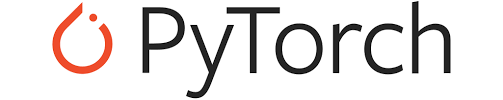

<a id="16"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>Directory Settings<center><h2>

In [ ]:
import os

MODEL_DIR = '../input/ranzcr-resnext50-32x4d-starter-training/'
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TEST_PATH = '../input/ranzcr-clip-catheter-line-classification/test'

<a id="17"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>Context-Free Grammar (CFG)<center><h2>

In [ ]:
class CFG:
    debug=False
    num_workers=4
    model_name='resnext50_32x4d'
    size=600
    batch_size=64
    seed=42
    target_size=11
    target_cols=['ETT - Abnormal', 
                 'ETT - Borderline', 
                 'ETT - Normal',
                 'NGT - Abnormal',
                 'NGT - Borderline', 
                 'NGT - Incompletely Imaged',
                 'NGT - Normal', 
                 'CVC - Abnormal', 
                 'CVC - Borderline',
                 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    n_fold=4
    trn_fold=[0, 1, 2, 3]

<a id="18"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>Library Using on The Datasets<center><h2>

In [ ]:
import sys

sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import (defaultdict,
                         Counter)

import scipy as sp
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (StratifiedKFold, 
                                     GroupKFold, 
                                     KFold)

from tqdm.auto import tqdm
from functools import partial

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import (DataLoader,
                              Dataset)
from torch.optim.lr_scheduler import (CosineAnnealingWarmRestarts, 
                                      CosineAnnealingLR,
                                      ReduceLROnPlateau)

from albumentations import (Compose,
                            OneOf,
                            Normalize,
                            Resize,
                            RandomResizedCrop,
                            RandomCrop,
                            HorizontalFlip,
                            VerticalFlip, 
                            RandomBrightness,
                            RandomContrast,
                            RandomBrightnessContrast,
                            Rotate,
                            ShiftScaleRotate,
                            Cutout,
                            IAAAdditiveGaussianNoise,
                            Transpose)

from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

# import timm

from torch.cuda.amp import (autocast, 
                            GradScaler)

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<a id="19"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>Utils<center><h2>

In [ ]:
def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


def get_result(result_df):
    preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
    labels = result_df[CFG.target_cols].values
    score, scores = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'inference.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

<a id="20"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>Data Loading<center><h2>

In [ ]:
train = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train.csv')
folds = train.copy()
Fold = GroupKFold(n_splits=CFG.n_fold)
groups = folds['PatientID'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_cols], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())

In [ ]:
oof_df = pd.DataFrame()
for fold in CFG.trn_fold:
    valid_folds = folds[folds['fold']==fold].reset_index(drop=True)
    check_point = torch.load(MODEL_DIR+f'{CFG.model_name}_fold{fold}_best.pth', map_location=device)
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']
    LOGGER.info(f"========== fold: {fold} result ==========")
    get_result(valid_folds)
    oof_df = pd.concat([oof_df, valid_folds])
oof_df = oof_df.reset_index(drop=True)
LOGGER.info(f"========== CV ==========")
get_result(oof_df)

In [ ]:
test = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv')
print(test.shape)
test.head(10)

In [ ]:
test.isnull()

In [ ]:
test.isnull().sum()

In [ ]:
def testing():
    if CFG.debug:
        test = test.head()
    else:
        return ':)'
    
testing()

<a id="21"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>Dataset<center><h2>

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['StudyInstanceUID'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

train_dataset = TestDataset(test, transform=None)

for i in range(5):
    image = train_dataset[i]
    plt.imshow(image)
    plt.show()

<a id="22"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>Transforms<center><h2>

In [ ]:
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
train_dataset = TestDataset(test, transform=get_transforms(data='valid'))

for i in range(5):
    image = train_dataset[i]
    plt.imshow(image[0])
    plt.show() 

<a id="23"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>MODEL<center><h2>

In [ ]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

<a id="24"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>Helper Function<center><h2>

In [ ]:
def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.sigmoid().to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

<a id="25"></a>
<h2 style='background:#FFCD46; border:0; color:white'><center>Result<center><h2>

In [ ]:
!pip install timm

In [ ]:
import timm

model = CustomResNext(CFG.model_name, pretrained=False)
states = [torch.load(MODEL_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True)
predictions = inference(model, states, test_loader, device)
# submission
test[CFG.target_cols] = predictions
test[['StudyInstanceUID'] + CFG.target_cols].to_csv(OUTPUT_DIR+'submission.csv', index=False)


In [ ]:
test.head(10)